In [ ]:
import polars as pl
import tempfile
import zipfile
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from typing import cast

# Load the india grid
with tempfile.TemporaryDirectory() as tmpdir:
    zip_path = Path("../../grid_india_10km_shapefiles.zip")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(tmpdir)
        grid_path = Path(tmpdir, "grid_india_10km", "grid_india_10km.shp")
        
        grid = gpd.read_file(grid_path)
        # Convert grid_id to int and then to string
        grid["grid_id"] = grid["grid_id"].astype(int).astype(str)


In [41]:
expected = pl.read_parquet(
    "inputs/expected_imputation_2023_01"
)

# Convert date to string "YYYY-MM-DD"
expected = expected.with_columns(
    pl.col("date").dt.strftime("%Y-%m-%d").alias("date"),
)

actual = pl.read_parquet(
    "gs://crea-pm25ml-examples/combined__omi_full_nn.parquet"
)

# Join expected and actual dataframes on 'date' and 'grid_id'
joined = (
    expected
        .join(
            actual,
            on=["date", "grid_id"],
            how="full",
            suffix="_actual",
        )
        .sort(["grid_id", "date"])
        .with_columns(
            pl.col("date").str.strptime(pl.Date, "%Y-%m-%d", strict=False).alias("date")
        )
)

In [42]:
rolling_days = 7

joined = joined.with_columns(
    omi_no2__no2_rolling_mean=pl.col("omi_no2__no2")
        .fill_nan(None)
        .rolling_mean(window_size=rolling_days, min_samples=1, center=True)
        .over("grid_id", order_by="date", descending=False),
    omi_no2_v4__no2_rolling_mean=pl.col("omi_no2_v4__no2")
        .fill_nan(None)
        .rolling_mean(window_size=rolling_days, min_samples=1, center=True)
        .over("grid_id", order_by="date", descending=False),
    omi_no2__no2_temporal_interpolated=pl.col("omi_no2__no2").fill_nan(None).interpolate(method="linear").over("grid_id"),
    omi_no2_v4__no2_temporal_interpolated=pl.col("omi_no2_v4__no2").fill_nan(None).interpolate(method="linear").over("grid_id"),
    # Okay, instead of interpolating, can we just fill forward?
    omi_no2__no2_filled_forward=pl.col("omi_no2__no2").fill_nan(None).fill_null(strategy="forward").over("grid_id"),
    omi_no2_v4__no2_filled_forward=pl.col("omi_no2_v4__no2").fill_nan(None).fill_null(strategy="forward").over("grid_id"),
    omi_no2__no2_cloud_screened_rolling_mean=pl.col("omi_no2__no2_cloud_screened")
        .fill_nan(None)
        .rolling_mean(window_size=rolling_days, min_samples=1, center=True)
        .over("grid_id", order_by="date", descending=False),
    omi_no2__no2_trop_rolling_mean=pl.col("omi_no2__no2_trop")
        .fill_nan(None)
        .rolling_mean(window_size=rolling_days, min_samples=1, center=True)
        .over("grid_id", order_by="date", descending=False),
    omi_no2__no2_trop_cloud_screened_rolling_mean=pl.col("omi_no2__no2_trop_cloud_screened")
        .fill_nan(None)
        .rolling_mean(window_size=rolling_days, min_samples=1, center=True)
        .over("grid_id", order_by="date", descending=False),
    omi_no2_v4__no2_cloud_screened_rolling_mean=pl.col("omi_no2_v4__no2_cloud_screened")
        .fill_nan(None)
        .rolling_mean(window_size=rolling_days, min_samples=1, center=True)
        .over("grid_id", order_by="date", descending=False),
    omi_no2_v4__no2_trop_rolling_mean=pl.col("omi_no2_v4__no2_trop")
        .fill_nan(None)
        .rolling_mean(window_size=rolling_days, min_samples=1, center=True)
        .over("grid_id", order_by="date", descending=False),
    omi_no2_v4__no2_trop_cloud_screened_rolling_mean=pl.col("omi_no2_v4__no2_trop_cloud_screened")
        .fill_nan(None)
        .rolling_mean(window_size=rolling_days, min_samples=1, center=True)
        .over("grid_id", order_by="date", descending=False),
)

In [43]:
# Convert joined to pandas
joined_pd = joined.to_pandas()
grid = grid.copy()
grid.reset_index(inplace=True)
# Set grid_id as index
joined_pd["grid_id"] = joined_pd["grid_id"].astype(int)
grid["grid_id"] = grid["grid_id"].astype(int)
joined_pd.set_index("grid_id", inplace=True)
grid.set_index("grid_id", inplace=True)

# Join to the grid by grid_id
joined_gdf = grid.join(
    joined_pd,
    on="grid_id",
    how="left",
)
joined_gdf = joined_gdf.to_crs("EPSG:4326")  # Convert to WGS84

In [44]:
india_gdf = joined_gdf.to_crs(epsg=7755)

In [45]:
del joined_gdf
del joined_pd
del grid
del joined
del expected
del actual

In [46]:
india_translated_geom = india_gdf.copy().geometry.translate(-0.125, -0.125).to_crs("EPSG:7755")
india_translated_gdf = gpd.GeoDataFrame(india_gdf.copy(), geometry=india_translated_geom, crs="EPSG:7755").reset_index()

translated_with_only_our_omi_no2 = india_translated_gdf[[
    "grid_id", "geometry", "date", "omi_no2__no2",
]][india_translated_gdf["omi_no2__no2"].notna() & india_translated_gdf["omi_no2__no2"].notnull()]


In [47]:
del india_translated_gdf
del india_translated_geom

In [60]:
def nearest_join_by_date(india_gdf, india_translated_gdf):
    for date_val, group in india_gdf.groupby('date'):
        if pd.to_datetime(date_val) > pd.to_datetime("2023-01-30"):
            continue
        group_gdf = gpd.GeoDataFrame(group, geometry=group.geometry, crs="EPSG:7755")
        right = india_translated_gdf[india_translated_gdf['date'] == date_val]
        if not right.empty:
            yield gpd.sjoin_nearest(group_gdf, right, how='inner', max_distance=10000)

# Then either stream process or collect small chunks

final = pd.concat(list(nearest_join_by_date(india_gdf, translated_with_only_our_omi_no2)), ignore_index=True)

In [61]:
gdf = gpd.GeoDataFrame(
    final,
    geometry=final.geometry,
)

Text(0, 0.5, 'omi_no2__no2_right')

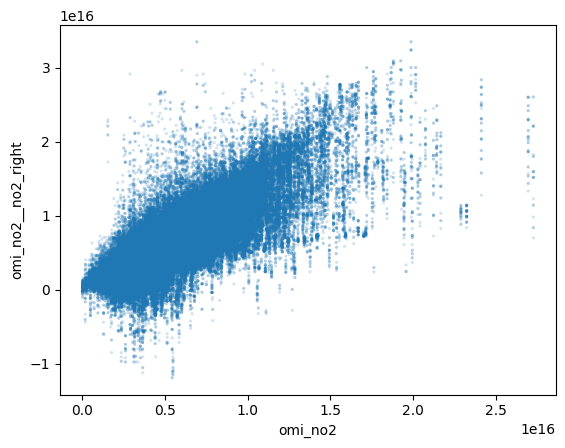

In [62]:
# Plot omi_no2 vs omi_no2__no2_right
fig = plt.subplot()

fig.scatter(
    gdf["omi_no2"],
    gdf["omi_no2__no2_right"],
    alpha=0.2,
    s=5,
    edgecolors='none',
)
fig.set_xlabel("omi_no2")
fig.set_ylabel("omi_no2__no2_right")


In [63]:
mean_gdf = gpd.GeoDataFrame(gdf[["geometry", "omi_no2", "omi_no2__no2_right"]].groupby("geometry").mean().reset_index(), geometry="geometry")

<Axes: >

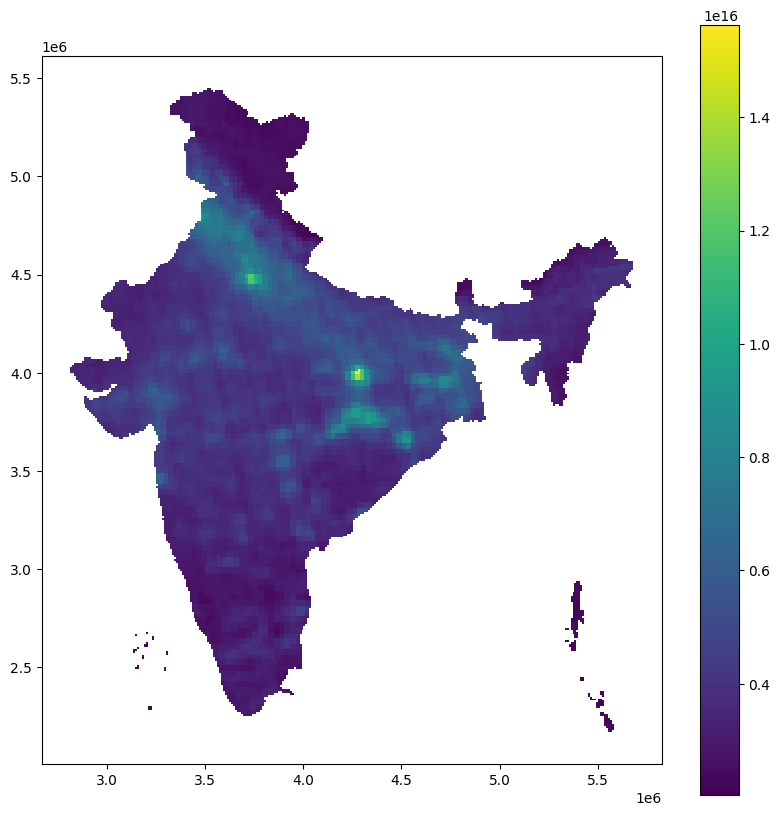

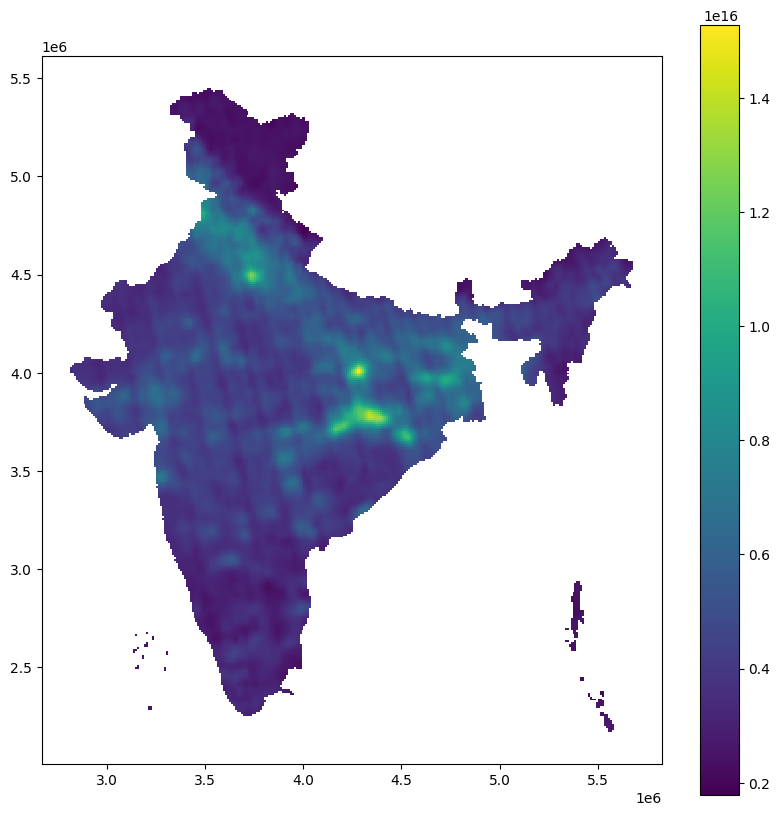

In [64]:
mean_gdf.plot(
    column="omi_no2",
    cmap="viridis",
    legend=True,
    figsize=(10, 10),
)

mean_gdf.plot(
    column="omi_no2__no2_right",
    cmap="viridis",
    legend=True,
    figsize=(10, 10),
)